In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Config

import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score

FILE_PATH = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv"
OUTPUT_PATH = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner_meta_goldclf.csv"

GOLD_COL = "Gold_Label"
LABEL_COL_BART = "bart_soa_label"
LABEL_COL_ROBERTA = "roberta_soa_label"
LABEL_COL_COMBINED = "combined_soa_label"

NUM_COLS = [
    "mean_agency_score",
    "bart-large-mnli_agency_score",
    "roberta-large-mnli_agency_score",
]

CAT_COLS = [
    LABEL_COL_BART,
    LABEL_COL_ROBERTA,
    LABEL_COL_COMBINED,
]

VALID_LABELS = ["POS_SOA", "NEG_SOA", "NON_SOA"]


# 2. Load data

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

df = pd.read_csv(FILE_PATH)
print(f"Loaded {len(df)} rows from: {FILE_PATH}")

if GOLD_COL not in df.columns:
    raise KeyError(f"Expected gold column '{GOLD_COL}' not in file.")

# keep only proper gold labels
mask_gold = df[GOLD_COL].isin(VALID_LABELS)
df_gold = df[mask_gold].copy().reset_index(drop=True)
print(f"Gold-labeled rows: {len(df_gold)}")


# 3. Helper: evaluate a model’s labels vs gold

def eval_vs_gold(pred_col, name):
    if pred_col not in df_gold.columns:
        print(f"\n[{name}] Column '{pred_col}' not found, skipping.")
        return

    y_true = df_gold[GOLD_COL]
    y_pred = df_gold[pred_col]

    # restrict to rows where pred is valid
    mask = y_pred.isin(VALID_LABELS)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        print(f"\n[{name}] No valid predictions after filtering, skipping.")
        return

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"\n=== {name} vs GOLD ({GOLD_COL}) ===")
    print(f"Accuracy:   {acc:.3f}")
    print(f"Macro F1:   {macro_f1:.3f}")
    print(f"Cohen's κ:  {kappa:.3f}")
    print("\nConfusion matrix (rows=gold, cols=model):")
    print(confusion_matrix(y_true, y_pred, labels=VALID_LABELS))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, labels=VALID_LABELS, digits=3))


# 4. Baseline evaluations: BART, RoBERTa, Combined

eval_vs_gold(LABEL_COL_BART, "BART")
eval_vs_gold(LABEL_COL_ROBERTA, "RoBERTa")
eval_vs_gold(LABEL_COL_COMBINED, "Combined (winner-takes-strongest)")


# 5. Prepare features for supervised meta-classifier

# ensure numeric columns exist
for c in NUM_COLS:
    if c not in df_gold.columns:
        raise KeyError(f"Numeric feature column '{c}' not found in gold data.")

for c in CAT_COLS:
    if c not in df_gold.columns:
        raise KeyError(f"Categorical feature column '{c}' not found in gold data.")

# X, y for gold rows
X_gold = df_gold[NUM_COLS + CAT_COLS].copy()
y_gold = df_gold[GOLD_COL].copy()

# coerce numeric columns to float
for c in NUM_COLS:
    X_gold[c] = pd.to_numeric(X_gold[c], errors="coerce")

# drop rows with any NaNs in features or labels
mask_valid = X_gold[NUM_COLS].notna().all(axis=1) & X_gold[CAT_COLS].notna().all(axis=1) & y_gold.notna()
X_gold = X_gold[mask_valid]
y_gold = y_gold[mask_valid].reset_index(drop=True)
print(f"\nGold rows after dropping missing features: {len(X_gold)}")

# column transformer: scale numeric, one-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
    ]
)

clf = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=200,
    solver="lbfgs",
    n_jobs=-1,
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", clf),
    ]
)


# 6. Cross-validation on gold rows

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(
    pipeline, X_gold, y_gold, cv=cv, scoring="accuracy"
)
f1_macro_scores = cross_val_score(
    pipeline, X_gold, y_gold, cv=cv, scoring="f1_macro"
)

print("\n=== Meta-classifier (LogReg) cross-validation on GOLD ===")
print(f"Accuracy:   mean={acc_scores.mean():.3f}, std={acc_scores.std():.3f}")
print(f"Macro F1:   mean={f1_macro_scores.mean():.3f}, std={f1_macro_scores.std():.3f}")

# fit on all gold rows
pipeline.fit(X_gold, y_gold)
print("\nFitted meta-classifier on all gold rows.")


# 7. Apply meta-classifier to full dataset

# build full feature matrix with same columns
X_all = df[NUM_COLS + CAT_COLS].copy()

# coerce numeric columns
for c in NUM_COLS:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

# For rows with missing features, we'll leave predictions as NaN
mask_all_valid = X_all[NUM_COLS].notna().all(axis=1) & X_all[CAT_COLS].notna().all(axis=1)

print(f"\nTotal rows: {len(df)}")
print(f"Rows with complete features for meta-classifier: {mask_all_valid.sum()}")

meta_pred = np.array(["MISSING"] * len(df), dtype=object)
meta_rel = np.array([np.nan] * len(df), dtype=object)
meta_proba_pos = np.full(len(df), np.nan, dtype=float)
meta_proba_neg = np.full(len(df), np.nan, dtype=float)
meta_proba_non = np.full(len(df), np.nan, dtype=float)

if mask_all_valid.any():
    X_valid = X_all.loc[mask_all_valid]
    y_pred_valid = pipeline.predict(X_valid)
    proba_valid = pipeline.predict_proba(X_valid)

    # map class probabilities to the fixed order VALID_LABELS
    class_order = pipeline.named_steps["clf"].classes_
    idx_pos = np.where(class_order == "POS_SOA")[0][0]
    idx_neg = np.where(class_order == "NEG_SOA")[0][0]
    idx_non = np.where(class_order == "NON_SOA")[0][0]

    meta_pred[mask_all_valid] = y_pred_valid
    meta_rel[mask_all_valid] = np.isin(y_pred_valid, ["POS_SOA", "NEG_SOA"])

    meta_proba_pos[mask_all_valid] = proba_valid[:, idx_pos]
    meta_proba_neg[mask_all_valid] = proba_valid[:, idx_neg]
    meta_proba_non[mask_all_valid] = proba_valid[:, idx_non]

# add columns to df
df["meta_soa_label"] = meta_pred
df["meta_agency_related"] = meta_rel
df["meta_proba_POS_SOA"] = meta_proba_pos
df["meta_proba_NEG_SOA"] = meta_proba_neg
df["meta_proba_NON_SOA"] = meta_proba_non

# 8. Optional: evaluate meta vs gold on gold subset

df_gold_meta = df.loc[mask_gold].copy()
mask_meta_valid_on_gold = df_gold_meta["meta_soa_label"].isin(VALID_LABELS)

y_true_gold = df_gold_meta.loc[mask_meta_valid_on_gold, GOLD_COL]
y_pred_meta = df_gold_meta.loc[mask_meta_valid_on_gold, "meta_soa_label"]

if len(y_true_gold) > 0:
    acc_meta = accuracy_score(y_true_gold, y_pred_meta)
    f1_meta = f1_score(y_true_gold, y_pred_meta, average="macro")
    kappa_meta = cohen_kappa_score(y_true_gold, y_pred_meta)

    print("\n=== Meta-classifier vs GOLD on gold rows ===")
    print(f"Accuracy:   {acc_meta:.3f}")
    print(f"Macro F1:   {f1_meta:.3f}")
    print(f"Cohen's κ:  {kappa_meta:.3f}")
    print("\nConfusion matrix (rows=gold, cols=meta):")
    print(confusion_matrix(y_true_gold, y_pred_meta, labels=VALID_LABELS))
    print("\nClassification report:")
    print(classification_report(y_true_gold, y_pred_meta, labels=VALID_LABELS, digits=3))
else:
    print("\nNo valid meta predictions on gold rows; cannot evaluate meta vs gold.")


# 9. Save updated file

df.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved updated file with meta_soa_label to:\n  {OUTPUT_PATH}")


/tmp/ipython-input-443049955.py:48: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Loaded 63092 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv
Gold-labeled rows: 305

=== BART vs GOLD (Gold_Label) ===
Accuracy:   0.400
Macro F1:   0.374
Cohen's κ:  0.103

Confusion matrix (rows=gold, cols=model):
[[27 61 42]
 [17 72 37]
 [ 6 20 23]]

Classification report:
              precision    recall  f1-score   support

     POS_SOA      0.540     0.208     0.300       130
     NEG_SOA      0.471     0.571     0.516       126
     NON_SOA      0.225     0.469     0.305        49

    accuracy                          0.400       305
   macro avg      0.412     0.416     0.374       305
weighted avg      0.461     0.400     0.390       305


=== RoBERTa vs GOLD (Gold_Label) ===
Accuracy:   0.259
Macro F1:   0.237
Cohen's κ:  0.030

Confusion matrix (rows=gold, cols=model):
[[31  1 98]
 [40  7 79]
 [ 5  3 41]]

Classification report:
              precision    recall  f1-score   support

     POS_SOA      0.408     0.238     0.301

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


=== Meta-classifier (LogReg) cross-validation on GOLD ===
Accuracy:   mean=0.387, std=0.029
Macro F1:   mean=0.368, std=0.030

Fitted meta-classifier on all gold rows.

Total rows: 63092
Rows with complete features for meta-classifier: 63083


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Meta-classifier vs GOLD on gold rows ===
Accuracy:   0.426
Macro F1:   0.416
Cohen's κ:  0.145

Confusion matrix (rows=gold, cols=meta):
[[39 45 46]
 [31 63 32]
 [10 11 28]]

Classification report:
              precision    recall  f1-score   support

     POS_SOA      0.487     0.300     0.371       130
     NEG_SOA      0.529     0.500     0.514       126
     NON_SOA      0.264     0.571     0.361        49

    accuracy                          0.426       305
   macro avg      0.427     0.457     0.416       305
weighted avg      0.469     0.426     0.429       305


Saved updated file with meta_soa_label to:
  /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner_meta_goldclf.csv


In [ ]:
import os
import gc  # NEW: for manual cleanup
import numpy as np
import pandas as pd

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    confusion_matrix,
    classification_report,
)

import torch  # NEW: you use torch later

# 1. Config

FILE_PATH = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv"
OUTPUT_CSV = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv"

# Base MNLI model
MNLI_MODEL_NAME = "facebook/bart-large-mnli"

# Where to save intermediate and final models
STAGE1_MODEL_DIR = "/content/drive/MyDrive/NLP /bart_goldclf_stage1_weak"
FINAL_MODEL_DIR  = "/content/drive/MyDrive/NLP /bart_goldclf_stage2_gold"

# Hypothesis text for NLI-style input
HYPOTHESIS_TEXT = (
    "The proposition refers to the ability of humans to make choices, "
    "exert control, or take responsibility for the actions and outcomes of AI."
)

# SoA label mapping
LABEL_MAP = {"POS_SOA": 0, "NEG_SOA": 1, "NON_SOA": 2}
ID2LABEL = {v: k for k, v in LABEL_MAP.items()}

# How many weakly-labeled rows to use:
# unlabeled ≈ UNLABELED_MULTIPLIER * gold_rows (≈ 9:1, i.e., 90% weak, 10% gold)
UNLABELED_MULTIPLIER = 9

# Training hyperparameters
RANDOM_SEED = 42
# LOWERED FOR GPU MEMORY SAFETY
MAX_LENGTH = 128  # was 256
STAGE1_EPOCHS = 2
STAGE2_EPOCHS = 3
# LOWERED FOR GPU MEMORY SAFETY
BATCH_SIZE = 8    # was 16
LR_STAGE1 = 2e-5
LR_STAGE2 = 1e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

set_seed(RANDOM_SEED)

# 2. Load data

df = pd.read_csv(FILE_PATH)
print(f"Loaded {len(df)} rows from: {FILE_PATH}")

if "proposition" not in df.columns:
    raise KeyError("Column 'proposition' not found in input CSV.")

for col in ["Gold_Label", "bart_soa_label"]:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in input CSV.")

# 3. Build gold and weak subsets

# Gold-labeled rows
df_gold = df[df["Gold_Label"].notna()].copy()
df_gold = df_gold[df_gold["proposition"].notna()].copy()
print(f"Gold-labeled rows: {len(df_gold)}")

# Weakly-labeled candidate rows: no Gold_Label, but BART label present
df_weak_candidates = df[
    df["Gold_Label"].isna() & df["bart_soa_label"].notna() & df["proposition"].notna()
].copy()
print(f"Weak-labeled candidates: {len(df_weak_candidates)}")

# Decide how many weak rows to sample (approx 9:1 weak:gold by default)
target_weak = min(len(df_weak_candidates), UNLABELED_MULTIPLIER * len(df_gold))
df_weak = df_weak_candidates.sample(
    n=target_weak, random_state=RANDOM_SEED, replace=False
).copy()
print(f"Weak-labeled subset used for Stage 1: {len(df_weak)} rows")

# 4. Map labels -> integers

def map_labels(series, label_name):
    unknown = sorted(set(series.dropna()) - set(LABEL_MAP.keys()))
    if unknown:
        print(f"WARNING: {label_name} contains unexpected labels: {unknown}")
    return series.map(LABEL_MAP)

df_gold["label_id"] = map_labels(df_gold["Gold_Label"], "Gold_Label")
df_weak["label_id"] = map_labels(df_weak["bart_soa_label"], "bart_soa_label")

# Drop rows where mapping failed
df_gold = df_gold[df_gold["label_id"].notna()].copy()
df_weak = df_weak[df_weak["label_id"].notna()].copy()

df_gold["label_id"] = df_gold["label_id"].astype(int)
df_weak["label_id"] = df_weak["label_id"].astype(int)

print(f"Gold rows after valid label mapping: {len(df_gold)}")
print(f"Weak rows after valid label mapping: {len(df_weak)}")

# 5. Build HF datasets + tokenizer

tokenizer = AutoTokenizer.from_pretrained(MNLI_MODEL_NAME, use_fast=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_with_labels(batch):
    enc = tokenizer(
        batch["proposition"],
        [HYPOTHESIS_TEXT] * len(batch["proposition"]),
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )
    enc["labels"] = batch["label_id"]
    return enc

# Stage 1 dataset (weak pretraining)
hf_weak = Dataset.from_pandas(
    df_weak[["proposition", "label_id"]].reset_index(drop=True)
)
hf_weak = hf_weak.map(
    tokenize_with_labels,
    batched=True,
    remove_columns=hf_weak.column_names,
)
hf_weak.set_format(type="torch")

# Stage 2 dataset (gold fine-tuning)
hf_gold = Dataset.from_pandas(
    df_gold[["proposition", "label_id"]].reset_index(drop=True)
)
hf_gold = hf_gold.map(
    tokenize_with_labels,
    batched=True,
    remove_columns=hf_gold.column_names,
)
hf_gold.set_format(type="torch")

print(f"HF weak dataset: {hf_weak}")
print(f"HF gold dataset: {hf_gold}")

# 6. Stage 1 – weak pretraining on BART labels

model_stage1 = AutoModelForSequenceClassification.from_pretrained(
    MNLI_MODEL_NAME,
    num_labels=3,
    id2label=ID2LABEL,
    label2id=LABEL_MAP,
)

training_args_stage1 = TrainingArguments(
    output_dir=STAGE1_MODEL_DIR,
    num_train_epochs=STAGE1_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_STAGE1,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,
    fp16=False,
    report_to="none",
    gradient_accumulation_steps=1,  # keep simple; adjust if you still get OOM
)

trainer_stage1 = Trainer(
    model=model_stage1,
    args=training_args_stage1,
    train_dataset=hf_weak,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("\n=== Stage 1: weak pretraining on BART SoA labels (subset) ===")
trainer_stage1.train()

os.makedirs(STAGE1_MODEL_DIR, exist_ok=True)
model_stage1.save_pretrained(STAGE1_MODEL_DIR)
tokenizer.save_pretrained(STAGE1_MODEL_DIR)
print(f"Saved Stage 1 model to: {STAGE1_MODEL_DIR}")

# --- CLEANUP: free Stage 1 before Stage 2 ---
del trainer_stage1
del model_stage1
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 7. Stage 2 – fine-tuning on gold labels

model_stage2 = AutoModelForSequenceClassification.from_pretrained(
    STAGE1_MODEL_DIR,
    num_labels=3,
    id2label=ID2LABEL,
    label2id=LABEL_MAP,
)

training_args_stage2 = TrainingArguments(
    output_dir=FINAL_MODEL_DIR,
    num_train_epochs=STAGE2_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_STAGE2,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    fp16=False,
    report_to="none",
    gradient_accumulation_steps=1,
)

trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=hf_gold,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("\n=== Stage 2: fine-tuning on Gold_Label ===")
trainer_stage2.train()

os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
model_stage2.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)
print(f"Saved final gold-tuned model to: {FINAL_MODEL_DIR}")

# 8. Inference on all rows with final model

device = "cuda" if (hasattr(model_stage2, "cuda") and torch.cuda.is_available()) else "cpu"
model_stage2.to(device)
model_stage2.eval()

# Only run on rows with a proposition
mask_has_text = df["proposition"].notna()
propositions_all = df.loc[mask_has_text, "proposition"].astype(str).tolist()
indices_all = df.loc[mask_has_text].index.tolist()

batch_size_infer = 64

pred_label_ids = []
pred_scores = []  # P(POS_SOA) - P(NEG_SOA)

with torch.no_grad():
    for i in range(0, len(propositions_all), batch_size_infer):
        batch_props = propositions_all[i : i + batch_size_infer]
        enc = tokenizer(
            batch_props,
            [HYPOTHESIS_TEXT] * len(batch_props),
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model_stage2(**enc)
        logits = outputs.logits  # (batch, 3)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # (batch, 3)

        # predicted labels + "agency score" = P(POS) - P(NEG)
        label_ids = probs.argmax(axis=1)
        scores = probs[:, LABEL_MAP["POS_SOA"]] - probs[:, LABEL_MAP["NEG_SOA"]]

        pred_label_ids.extend(label_ids.tolist())
        pred_scores.extend(scores.tolist())

# Attach predictions back to df
pred_labels_str = [ID2LABEL[i] for i in pred_label_ids]

df["bart_goldclf_soa_label"] = np.nan
df["bart_goldclf_agency_score"] = np.nan
df["bart_goldclf_agency_related"] = np.nan

df.loc[indices_all, "bart_goldclf_soa_label"] = pred_labels_str
df.loc[indices_all, "bart_goldclf_agency_score"] = pred_scores
df.loc[indices_all, "bart_goldclf_agency_related"] = df.loc[
    indices_all, "bart_goldclf_soa_label"
].isin(["POS_SOA", "NEG_SOA"])

df.to_csv(OUTPUT_CSV, index=False)
print(f"\nSaved updated file with bart_goldclf_* columns to:\n  {OUTPUT_CSV}")

# 9. Evaluation vs gold labels

df_eval = df[df["Gold_Label"].notna() & df["bart_goldclf_soa_label"].notna()].copy()
print(f"\nGold rows available for evaluation of gold-tuned BART: {len(df_eval)}")

y_true = df_eval["Gold_Label"].map(LABEL_MAP).astype(int).values
y_pred = df_eval["bart_goldclf_soa_label"].map(LABEL_MAP).astype(int).values

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

print("\n=== Gold-tuned BART (bart_goldclf_soa_label) vs GOLD (Gold_Label) ===")
print(f"Accuracy:   {acc:.3f}")
print(f"Macro F1:   {macro_f1:.3f}")
print(f"Cohen's κ:  {kappa:.3f}")

print("\nConfusion matrix (rows=gold, cols=gold-tuned BART):")
print("Rows / cols order: POS_SOA=0, NEG_SOA=1, NON_SOA=2\n", cm)

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["POS_SOA", "NEG_SOA", "NON_SOA"],
        digits=3,
    )
)


/tmp/ipython-input-3455721800.py:69: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH)


Loaded 63092 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv
Gold-labeled rows: 305
Weak-labeled candidates: 62779
Weak-labeled subset used for Stage 1: 2745 rows
Gold rows after valid label mapping: 305
Weak rows after valid label mapping: 2745


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/2745 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

HF weak dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2745
})
HF gold dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 305
})


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

/tmp/ipython-input-3455721800.py:186: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage1 = Trainer(



=== Stage 1: weak pretraining on BART SoA labels (subset) ===


Step,Training Loss
100,1.182800
200,0.935300
300,0.897600
400,0.814500
500,0.704200
600,0.638800


Saved Stage 1 model to: /content/drive/MyDrive/NLP /bart_goldclf_stage1_weak


/tmp/ipython-input-3455721800.py:235: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage2 = Trainer(



=== Stage 2: fine-tuning on Gold_Label ===


Step,Training Loss
50,1.093100
100,0.740100


Saved final gold-tuned model to: /content/drive/MyDrive/NLP /bart_goldclf_stage2_gold


/tmp/ipython-input-3455721800.py:297: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['NON_SOA', 'NEG_SOA', 'NEG_SOA', 'POS_SOA', 'POS_SOA', 'NON_SOA', 'NON_SOA', 'NEG_SOA', 'NON_SOA', 'POS_SOA', 'POS_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'NEG_SOA', 'NON_SOA', 'NEG_SOA', 'NON_SOA', 'NEG_SOA', 'POS_SOA', 'NEG_SOA', 'POS_SOA', 'NEG_SOA', 'NON_SOA', 'POS_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'POS_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NON_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'NON_SOA', 'NON_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'POS_SOA', 'POS_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NON_SOA', 'NEG_SOA', 'NON_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NEG_SOA', 'NON_SOA', 'POS_SOA', 'NEG_SOA', 'POS_SOA', 'NEG_SOA', 'POS_SOA', 'NEG_SO


Saved updated file with bart_goldclf_* columns to:
  /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv

Gold rows available for evaluation of gold-tuned BART: 305

=== Gold-tuned BART (bart_goldclf_soa_label) vs GOLD (Gold_Label) ===
Accuracy:   0.797
Macro F1:   0.782
Cohen's κ:  0.670

Confusion matrix (rows=gold, cols=gold-tuned BART):
Rows / cols order: POS_SOA=0, NEG_SOA=1, NON_SOA=2
 [[ 95  29   6]
 [  9 115   2]
 [ 11   5  33]]

Classification report:
              precision    recall  f1-score   support

     POS_SOA      0.826     0.731     0.776       130
     NEG_SOA      0.772     0.913     0.836       126
     NON_SOA      0.805     0.673     0.733        49

    accuracy                          0.797       305
   macro avg      0.801     0.772     0.782       305
weighted avg      0.800     0.797     0.794       305



/tmp/ipython-input-3987065576.py:38: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


Loaded 63092 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv
bart_soa_label: dropping unexpected labels ['0.504651189']
roberta_soa_label: dropping unexpected labels ['TRUE']
Rows after dropping missing mean_agency_score: 63084

=== Overall distribution of combined mean_agency_score ===
count    63084.000000
mean        -0.047493
std          0.334543
min         -0.993539
25%         -0.318249
50%         -0.062056
75%          0.199319
max          0.951101
Name: mean_agency_score, dtype: float64
Mean agency score (95% CI): -0.047 [-0.050, -0.045]


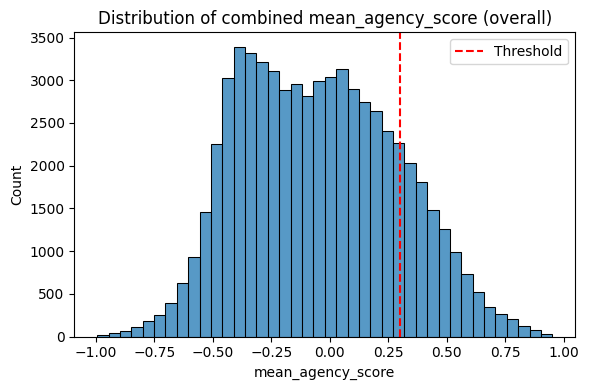


=== Combined 3-way label counts ===
combined_soa_label
NEG_SOA    30095
POS_SOA    17278
NON_SOA    15711
Name: count, dtype: int64

=== Group-wise descriptives for mean_agency_score by combined label ===

Label: NEG_SOA
count    30095.000000
mean        -0.333825
std          0.164448
min         -0.993539
25%         -0.438974
50%         -0.329231
75%         -0.211723
max         -0.000150
Name: mean_agency_score, dtype: float64
Mean (95% CI): -0.334 [-0.336, -0.332]

Label: NON_SOA
count    15711.000000
mean         0.048350
std          0.105782
min         -0.294370
25%         -0.027278
50%          0.048580
75%          0.128303
max          0.297796
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.048 [0.047, 0.050]

Label: POS_SOA
count    17278.000000
mean         0.364091
std          0.175469
min          0.000144
25%          0.247124
50%          0.349041
75%          0.472525
max          0.951101
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.364 [0

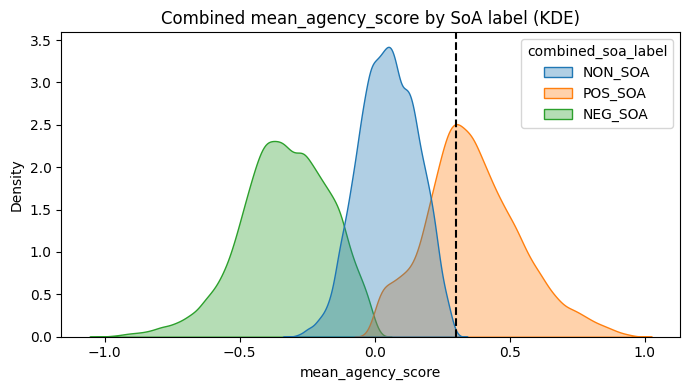


=== BART agency score stats ===
count    63083.000000
mean        -0.226929
std          0.556597
min         -0.999525
25%         -0.753149
50%         -0.260062
75%          0.220774
max          0.987875
Name: bart-large-mnli_agency_score, dtype: float64

=== RoBERTa agency score stats ===
count    63084.000000
mean         0.131938
std          0.232647
min         -0.994487
25%          0.013224
50%          0.128946
75%          0.258929
max          0.956430
Name: roberta-large-mnli_agency_score, dtype: float64

=== Gold-tuned BART agency score stats ===
count    63084.000000
mean        -0.048436
std          0.537934
min         -0.919194
25%         -0.561472
50%         -0.054963
75%          0.441646
max          0.860902
Name: bart_goldclf_agency_score, dtype: float64

Correlation matrix between model-specific agency scores:
                                 bart-large-mnli_agency_score  \
bart-large-mnli_agency_score                         1.000000   
roberta-large-mnli

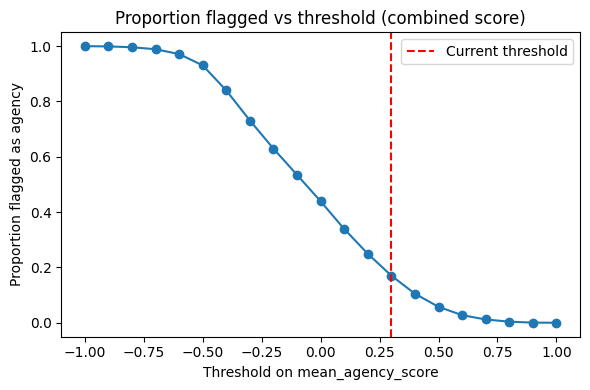


=== Label distributions per method ===

bart_soa_label:
bart_soa_label
NEG_SOA    30385
NON_SOA    19321
POS_SOA    13377
NaN            1
Name: count, dtype: int64

roberta_soa_label:
roberta_soa_label
NON_SOA    48288
POS_SOA    12332
NEG_SOA     2463
NaN            1
Name: count, dtype: int64

combined_soa_label:
combined_soa_label
NEG_SOA    30095
POS_SOA    17278
NON_SOA    15711
Name: count, dtype: int64

bart_goldclf_soa_label:
bart_goldclf_soa_label
NEG_SOA    29557
POS_SOA    22978
NON_SOA    10549
Name: count, dtype: int64

=== Pairwise agreement (percent agreement + Cohen's kappa) ===

Pair: bart_soa_label vs roberta_soa_label
  Percent agreement: 0.356
  Cohen's kappa:    0.087
  Confusion matrix:
roberta_soa_label  POS_SOA  NEG_SOA  NON_SOA
bart_soa_label                              
POS_SOA               4808      192     8377
NEG_SOA               4232     1953    24200
NON_SOA               3292      318    15711

Pair: bart_soa_label vs combined_soa_label
  Percent a

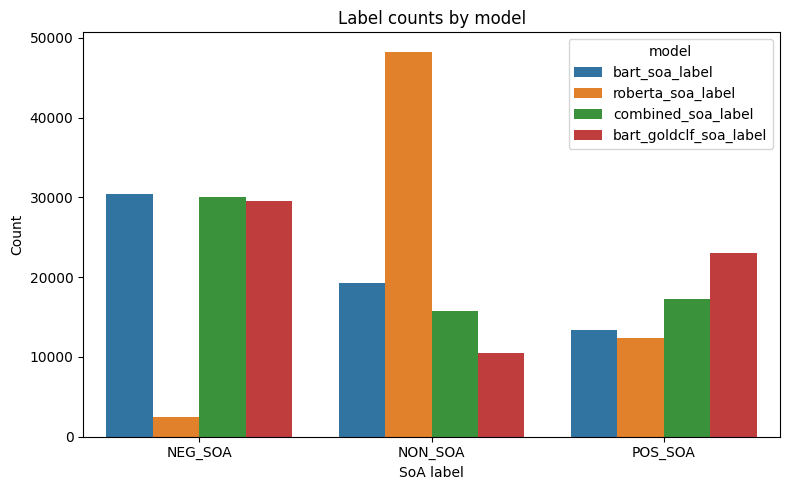


Gold rows available for evaluation of bart_goldclf_soa_label: 305

=== Gold-tuned BART vs GOLD (Gold_Label) ===
Accuracy:   0.797
Macro F1:   0.782
Cohen's κ:  0.670

Confusion matrix (rows=gold, cols=gold-tuned BART):
Rows / cols order: POS_SOA=0, NEG_SOA=1, NON_SOA=2
 [[ 95  29   6]
 [  9 115   2]
 [ 11   5  33]]

Classification report:
              precision    recall  f1-score   support

     POS_SOA      0.826     0.731     0.776       130
     NEG_SOA      0.772     0.913     0.836       126
     NON_SOA      0.805     0.673     0.733        49

    accuracy                          0.797       305
   macro avg      0.801     0.772     0.782       305
weighted avg      0.800     0.797     0.794       305



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    confusion_matrix,
    classification_report,
)

# 1. Config

# Use the gold-tuned file
INPUT_FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv"

AGENCY_THRESHOLD = 0.3  # just for reference/plots

# Continuous score columns
SCORE_COL_COMBINED   = "mean_agency_score"
SCORE_COL_BART       = "bart-large-mnli_agency_score"
SCORE_COL_ROBERTA    = "roberta-large-mnli_agency_score"
SCORE_COL_GOLDCLF    = "bart_goldclf_agency_score"

# Label columns
LABEL_COL_BART       = "bart_soa_label"
LABEL_COL_ROBERTA    = "roberta_soa_label"
LABEL_COL_COMBINED   = "combined_soa_label"
LABEL_COL_GOLDCLF    = "bart_goldclf_soa_label"
GOLD_LABEL_COL       = "Gold_Label"  # optional, for eval vs gold

VALID_LABELS = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# 2. Load data

df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df)} rows from: {INPUT_FILE}")

label_cols = [
    "bart_soa_label",
    "roberta_soa_label",
    "combined_soa_label",
    "bart_goldclf_soa_label",
]

for c in label_cols:
    if c not in df.columns:
        continue

    # Find weird labels
    bad_vals = df.loc[df[c].notna() & ~df[c].isin(VALID_LABELS), c].unique()
    if len(bad_vals) > 0:
        print(f"{c}: dropping unexpected labels {bad_vals}")

    # Set any non-standard values to NaN so they’re ignored downstream
    df.loc[~df[c].isin(VALID_LABELS), c] = np.nan

for c in [
    SCORE_COL_COMBINED,
    SCORE_COL_BART,
    SCORE_COL_ROBERTA,
    SCORE_COL_GOLDCLF,
    LABEL_COL_BART,
    LABEL_COL_ROBERTA,
    LABEL_COL_COMBINED,
    LABEL_COL_GOLDCLF,
]:
    if c not in df.columns:
        print(f"WARNING: expected column '{c}' not found in input.")

# coerce scores to numeric
for col in [
    SCORE_COL_COMBINED,
    SCORE_COL_BART,
    SCORE_COL_ROBERTA,
    SCORE_COL_GOLDCLF,
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# drop rows with no combined score
df = df.dropna(subset=[SCORE_COL_COMBINED])
print(f"Rows after dropping missing {SCORE_COL_COMBINED}: {len(df)}")

# 3. Helper: mean + CI

def mean_confidence_interval(x, confidence=0.95):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    m = np.mean(x)
    se = stats.sem(x)
    h = se * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h

# 4. Overall descriptives for combined score

print("\n=== Overall distribution of combined mean_agency_score ===")
print(df[SCORE_COL_COMBINED].describe())
overall_mean, overall_lo, overall_hi = mean_confidence_interval(df[SCORE_COL_COMBINED])
print(
    f"Mean agency score (95% CI): {overall_mean:.3f} "
    f"[{overall_lo:.3f}, {overall_hi:.3f}]"
)

plt.figure(figsize=(6, 4))
sns.histplot(df[SCORE_COL_COMBINED], bins=40)
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Threshold")
plt.title("Distribution of combined mean_agency_score (overall)")
plt.xlabel(SCORE_COL_COMBINED)
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Distribution by 3-way combined label

if LABEL_COL_COMBINED in df.columns:
    print("\n=== Combined 3-way label counts ===")
    print(df[LABEL_COL_COMBINED].value_counts(dropna=False))

    print("\n=== Group-wise descriptives for mean_agency_score by combined label ===")
    for lab, sub in df.groupby(LABEL_COL_COMBINED):
        desc = sub[SCORE_COL_COMBINED].describe()
        m, lo, hi = mean_confidence_interval(sub[SCORE_COL_COMBINED])
        print(f"\nLabel: {lab}")
        print(desc)
        print(f"Mean (95% CI): {m:.3f} [{lo:.3f}, {hi:.3f}]")

    # KDE plot by label (same as before, shape-only)
    plt.figure(figsize=(7, 4))
    sns.kdeplot(
        data=df,
        x=SCORE_COL_COMBINED,
        hue=LABEL_COL_COMBINED,
        common_norm=False,
        fill=True,
        alpha=0.35,
    )
    plt.axvline(AGENCY_THRESHOLD, color="black", linestyle="--", label="Threshold")
    plt.title("Combined mean_agency_score by SoA label (KDE)")
    plt.xlabel(SCORE_COL_COMBINED)
    plt.tight_layout()
    plt.show()

# 6. Per-model descriptive stats (including gold-tuned BART)

if SCORE_COL_BART in df.columns:
    print("\n=== BART agency score stats ===")
    print(df[SCORE_COL_BART].describe())

if SCORE_COL_ROBERTA in df.columns:
    print("\n=== RoBERTa agency score stats ===")
    print(df[SCORE_COL_ROBERTA].describe())

if SCORE_COL_GOLDCLF in df.columns:
    print("\n=== Gold-tuned BART agency score stats ===")
    print(df[SCORE_COL_GOLDCLF].describe())

score_cols_present = [
    c
    for c in [SCORE_COL_BART, SCORE_COL_ROBERTA, SCORE_COL_GOLDCLF]
    if c in df.columns
]
if len(score_cols_present) >= 2:
    print("\nCorrelation matrix between model-specific agency scores:")
    print(df[score_cols_present].corr())

# 7. Threshold scan on combined score (unchanged)

def threshold_scan(scores, thresholds):
    results = []
    x = np.array(scores)
    for t in thresholds:
        mask = x > t
        n_flag = mask.sum()
        prop_flag = n_flag / len(x)
        mean_flag = x[mask].mean() if n_flag > 0 else np.nan
        mean_rest = x[~mask].mean() if n_flag < len(x) else np.nan
        results.append(
            {
                "threshold": t,
                "prop_flagged": prop_flag,
                "mean_flagged": mean_flag,
                "mean_unflagged": mean_rest,
            }
        )
    return pd.DataFrame(results)

thresholds = np.linspace(-1.0, 1.0, 21)
scan_df = threshold_scan(df[SCORE_COL_COMBINED].values, thresholds)

print("\n=== Threshold scan summary (combined score) ===")
print(scan_df.head(10))

plt.figure(figsize=(6, 4))
plt.plot(scan_df["threshold"], scan_df["prop_flagged"], marker="o")
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Current threshold")
plt.xlabel("Threshold on mean_agency_score")
plt.ylabel("Proportion flagged as agency")
plt.title("Proportion flagged vs threshold (combined score)")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Agreement metrics helpers

def cohen_kappa_nominal(y1, y2):
    """
    Cohen's kappa for two nominal labelings y1, y2 (arrays of strings).
    Returns:
      po: percent agreement
      kappa: Cohen's kappa
      cm: confusion matrix (rows=labels, cols=labels) in VALID_LABELS order
    """
    s1 = pd.Series(y1)
    s2 = pd.Series(y2)
    mask = s1.notna() & s2.notna()
    s1 = s1[mask]
    s2 = s2[mask]
    if len(s1) == 0:
        return np.nan, np.nan, None

    # Confusion matrix restricted to the three SoA labels,
    # with consistent row/column ordering
    cm = pd.crosstab(s1, s2)
    cm = cm.reindex(index=VALID_LABELS, columns=VALID_LABELS, fill_value=0)

    N = cm.values.sum()
    if N == 0:
        return np.nan, np.nan, cm

    po = np.trace(cm.values) / N

    # Let sklearn compute kappa on the same restricted label set
    kappa = cohen_kappa_score(s1, s2, labels=VALID_LABELS)

    return po, kappa, cm

def krippendorff_alpha_nominal(data_2d):
    df_r = pd.DataFrame(data_2d)
    long = df_r.stack().reset_index()
    long.columns = ["item", "rater", "value"]
    long = long.dropna(subset=["value"])

    cats, long["cat"] = np.unique(long["value"], return_inverse=True)
    item_cat = long.groupby(["item", "cat"])["rater"].count().unstack(fill_value=0)

    n_u = item_cat.sum(axis=1).values
    Do_num = 0.0
    total_weight = 0.0
    for idx, row in item_cat.iterrows():
        n = n_u[item_cat.index.get_loc(idx)]
        if n <= 1:
            continue
        counts = row.values
        Do_num += (counts * (n - counts)).sum() / (n - 1)
        total_weight += n
    Do = Do_num / total_weight if total_weight > 0 else np.nan

    cat_totals = item_cat.sum(axis=0).values
    N = cat_totals.sum()
    if N <= 1:
        return np.nan
    De = (cat_totals * (N - cat_totals)).sum() / ((N - 1) * N)
    if De == 0:
        return np.nan
    return 1 - Do / De

# 9. Agreement: pairwise + Krippendorff

label_cols = [
    LABEL_COL_BART,
    LABEL_COL_ROBERTA,
    LABEL_COL_COMBINED,
    LABEL_COL_GOLDCLF,
]
present_label_cols = [c for c in label_cols if c in df.columns]

print("\n=== Label distributions per method ===")
for c in present_label_cols:
    print(f"\n{c}:")
    print(df[c].value_counts(dropna=False))

# Pairwise Cohen's kappa (including gold-tuned BART)
pairs = [
    (LABEL_COL_BART, LABEL_COL_ROBERTA),
    (LABEL_COL_BART, LABEL_COL_COMBINED),
    (LABEL_COL_ROBERTA, LABEL_COL_COMBINED),
    (LABEL_COL_BART, LABEL_COL_GOLDCLF),
    (LABEL_COL_ROBERTA, LABEL_COL_GOLDCLF),
    (LABEL_COL_COMBINED, LABEL_COL_GOLDCLF),
]

print("\n=== Pairwise agreement (percent agreement + Cohen's kappa) ===")
for a, b in pairs:
    if a not in df.columns or b not in df.columns:
        continue
    pa, kappa, cm = cohen_kappa_nominal(df[a], df[b])
    print(f"\nPair: {a} vs {b}")
    print(f"  Percent agreement: {pa:.3f}")
    print(f"  Cohen's kappa:    {kappa:.3f}")
    print("  Confusion matrix:")
    print(cm)

# Krippendorff's alpha across all available methods
if len(present_label_cols) >= 2:
    ratings_mat = df[present_label_cols].values
    alpha = krippendorff_alpha_nominal(ratings_mat)
    print("\n=== Krippendorff's alpha (nominal, across all methods) ===")
    print(f"Alpha: {alpha:.3f}")
else:
    print("\nNot enough label columns to compute Krippendorff's alpha.")

# 10. NEW: volume / counts plot by model and label

count_records = []
for col in present_label_cols:
    vc = df[col].value_counts()
    for lab, cnt in vc.items():
        count_records.append({"model": col, "label": lab, "count": cnt})

count_df = pd.DataFrame(count_records)

plt.figure(figsize=(8, 5))
sns.barplot(data=count_df, x="label", y="count", hue="model")
plt.title("Label counts by model")
plt.xlabel("SoA label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 11. OPTIONAL: Evaluation vs gold labels for gold-tuned model

if GOLD_LABEL_COL in df.columns and LABEL_COL_GOLDCLF in df.columns:
    # drop rows with missing labels
    df_eval = df[df[GOLD_LABEL_COL].notna() & df[LABEL_COL_GOLDCLF].notna()].copy()
    print(f"\nGold rows available for evaluation of bart_goldclf_soa_label: {len(df_eval)}")

    label_map = {"POS_SOA": 0, "NEG_SOA": 1, "NON_SOA": 2}
    y_true = df_eval[GOLD_LABEL_COL].map(label_map).astype(int).values
    y_pred = df_eval[LABEL_COL_GOLDCLF].map(label_map).astype(int).values

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    kappa = cohen_kappa_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    print("\n=== Gold-tuned BART vs GOLD (Gold_Label) ===")
    print(f"Accuracy:   {acc:.3f}")
    print(f"Macro F1:   {macro_f1:.3f}")
    print(f"Cohen's κ:  {kappa:.3f}")

    print("\nConfusion matrix (rows=gold, cols=gold-tuned BART):")
    print("Rows / cols order: POS_SOA=0, NEG_SOA=1, NON_SOA=2\n", cm)

    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=["POS_SOA", "NEG_SOA", "NON_SOA"],
            digits=3,
        )
    )
else:
    print("\nGold labels not found; skipping evaluation vs Gold_Label.")


In [ ]:
for c in present_label_cols:
    print(c, sorted(df[c].dropna().unique()))

bart_soa_label ['0.504651189', 'NEG_SOA', 'NON_SOA', 'POS_SOA']
roberta_soa_label ['NEG_SOA', 'NON_SOA', 'POS_SOA', 'TRUE']
combined_soa_label ['NEG_SOA', 'NON_SOA', 'POS_SOA']
bart_goldclf_soa_label ['NEG_SOA', 'NON_SOA', 'POS_SOA']


In [ ]:
pip install hdbscan umap-learn bertopic sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from bertopic import BERTopic
from hdbscan import HDBSCAN
import umap
import torch

# 1. CONFIG

INPUT_SOA = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv"
OUTPUT_TOPICS_CSV = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf_with_bertopic.csv"
TOPIC_MODEL_DIR = "/content/drive/MyDrive/NLP /bertopic_soa_model"

TEXT_COL = "proposition"

EMBEDDING_MODEL = "all-MiniLM-L6-v2"   # light enough for ~63k rows
MIN_TOPIC_SIZE = 100
N_NEIGHBORS = 15
MIN_DIST = 0.0

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2. LOAD DATA

df = pd.read_csv(INPUT_SOA)
print(f"Loaded {len(df)} rows from {INPUT_SOA}")

if TEXT_COL not in df.columns:
    raise KeyError(f"Column '{TEXT_COL}' not found in input CSV.")

df = df[df[TEXT_COL].notna()].copy()
df[TEXT_COL] = df[TEXT_COL].astype(str)
print(f"Rows with non-empty {TEXT_COL}: {len(df)}")

docs = df[TEXT_COL].tolist()

# 3. BUILD BERTopic MODEL

umap_model = umap.UMAP(
    n_neighbors=N_NEIGHBORS,
    n_components=5,
    min_dist=MIN_DIST,
    metric="cosine",
    random_state=42,
)

hdbscan_model = HDBSCAN(
    min_cluster_size=MIN_TOPIC_SIZE,
    min_samples=5,
    prediction_data=True,
)

topic_model = BERTopic(
    embedding_model=EMBEDDING_MODEL,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=MIN_TOPIC_SIZE,
    verbose=True,
)

print("\n--- Fitting BERTopic on propositions ---")
topics, probs = topic_model.fit_transform(docs)
df["bertopic_topic"] = topics

# Create human-readable labels
topic_labels = {}
for topic_id in topic_model.get_topics().keys():
    if topic_id == -1:
        continue
    words = [w for w, _ in topic_model.get_topic(topic_id)[:5]]
    topic_labels[topic_id] = ", ".join(words[:4])

df["bertopic_topic_label"] = df["bertopic_topic"].map(topic_labels)

print("\nSample of topics:")
print(df[[TEXT_COL, "bertopic_topic", "bertopic_topic_label"]].head(10).to_string())

# 4. SAVE MODEL + CSV

topic_model.save(TOPIC_MODEL_DIR)
print(f"\nSaved BERTopic model to: {TOPIC_MODEL_DIR}")

df.to_csv(OUTPUT_TOPICS_CSV, index=False)
print(f"Saved topic-annotated CSV to:\n  {OUTPUT_TOPICS_CSV}")


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Using device: cuda


/tmp/ipython-input-2925002817.py:25: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_SOA)
2025-12-02 23:37:09,200 - BERTopic - Embedding - Transforming documents to embeddings.


Loaded 63092 rows from /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv
Rows with non-empty proposition: 63086

--- Fitting BERTopic on propositions ---


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1972 [00:00<?, ?it/s]

2025-12-02 23:38:10,591 - BERTopic - Embedding - Completed ✓
2025-12-02 23:38:10,592 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-02 23:39:50,935 - BERTopic - Dimensionality - Completed ✓
2025-12-02 23:39:50,937 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-02 23:39:56,183 - BERTopic - Cluster - Completed ✓
2025-12-02 23:39:56,201 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-02 23:39:58,761 - BERTopic - Representation - Completed ✓
2025-12-02 23:40:00,155 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Sample of topics:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  proposition  bertopic_topic                 bertopic_topic_label
0                                                                                                                                                                                                                                                                                                                 

In [ ]:
import pandas as pd

# NEW: modern plotting
import plotly.express as px

# 1. CONFIG

FILE_SOA_TOPICS = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf_with_bertopic.csv"

TEXT_COL = "proposition"
TOPIC_COL = "bertopic_topic"
TOPIC_LABEL_COL = "bertopic_topic_label"   # created in Script 1
LABEL_COL = "bart_goldclf_soa_label"       # custom gold-tuned classifier

TOP_N_TOPICS = 10
VALID_LABELS = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# 2. LOAD

df = pd.read_csv(FILE_SOA_TOPICS)
print(f"Loaded {len(df)} rows from: {FILE_SOA_TOPICS}")

for col in [TEXT_COL, TOPIC_COL, LABEL_COL]:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' must exist in the CSV.")

# keep only rows with valid labels
bad_vals = df.loc[df[LABEL_COL].notna() & ~df[LABEL_COL].isin(VALID_LABELS), LABEL_COL].unique()
if len(bad_vals) > 0:
    print(f"Dropping unexpected labels in {LABEL_COL}: {bad_vals}")
df = df[df[LABEL_COL].isin(VALID_LABELS)].copy()

# drop noise topic -1 if present
df = df[df[TOPIC_COL] != -1].copy()

print(f"Rows after filtering valid labels and non-noise topics: {len(df)}")

# 3. TOP N TOPICS BY VOLUME

topic_counts = df[TOPIC_COL].value_counts().sort_values(ascending=False)
top_topics = topic_counts.head(TOP_N_TOPICS).index.tolist()

print(f"\nTop {TOP_N_TOPICS} topics by count:")
print(topic_counts.head(TOP_N_TOPICS))

df_top = df[df[TOPIC_COL].isin(top_topics)].copy()

# human-readable topic names if available
if TOPIC_LABEL_COL in df_top.columns:
    topic_name_map = (
        df_top[[TOPIC_COL, TOPIC_LABEL_COL]]
        .dropna()
        .drop_duplicates()
        .set_index(TOPIC_COL)[TOPIC_LABEL_COL]
        .to_dict()
    )
else:
    topic_name_map = {}

# 4. COUNTS + PROPORTIONS

ct = pd.crosstab(df_top[TOPIC_COL], df_top[LABEL_COL])
ct = ct.reindex(index=top_topics)  # preserve order

# ensure all three labels are present
for lab in VALID_LABELS:
    if lab not in ct.columns:
        ct[lab] = 0

ct["total"] = ct[VALID_LABELS].sum(axis=1)
prop = ct[VALID_LABELS].div(ct["total"], axis=0)

summary = ct.copy()
for lab in VALID_LABELS:
    summary[f"{lab}_prop"] = prop[lab]

summary.index.name = "topic_id"
print("\n=== SoA label distribution per top BERTopic topic ===")
print(summary)

# 5. PLOTS (Plotly Express)

# Long format for counts
summary_counts_long = (
    summary[VALID_LABELS]
    .reset_index()
    .melt(
        id_vars="topic_id",
        value_vars=VALID_LABELS,
        var_name="SoA_label",
        value_name="count",
    )
)

summary_counts_long["topic_name"] = summary_counts_long["topic_id"].map(
    lambda tid: topic_name_map.get(tid, f"Topic {tid}")
)

# Preserve topic order by total volume
topic_order = (
    summary_counts_long.groupby("topic_name")["count"].sum()
    .sort_values(ascending=True)
    .index.tolist()
)

# 5.1 Counts per topic (horizontal stacked-ish bars)
fig_counts = px.bar(
    summary_counts_long,
    x="count",
    y="topic_name",
    color="SoA_label",
    category_orders={"topic_name": topic_order,
                     "SoA_label": VALID_LABELS},
    barmode="group",
    title="SoA label counts per top BERTopic topic (gold-tuned BART)",
    labels={
        "topic_name": "BERTopic topic",
        "count": "Number of propositions",
        "SoA_label": "SoA label",
    },
)

fig_counts.update_layout(
    template="plotly_white",
    legend_title_text="SoA label",
    title_x=0.0,
    margin=dict(l=10, r=10, t=40, b=40),
    height=500,
)
fig_counts.show()

# Long format for proportions
summary_prop_long = (
    summary[[f"{lab}_prop" for lab in VALID_LABELS]]
    .rename(columns={f"{lab}_prop": lab for lab in VALID_LABELS})
    .reset_index()
    .melt(
        id_vars="topic_id",
        value_vars=VALID_LABELS,
        var_name="SoA_label",
        value_name="proportion",
    )
)

summary_prop_long["topic_name"] = summary_prop_long["topic_id"].map(
    lambda tid: topic_name_map.get(tid, f"Topic {tid}")
)

fig_prop = px.bar(
    summary_prop_long,
    x="proportion",
    y="topic_name",
    color="SoA_label",
    category_orders={"topic_name": topic_order,
                     "SoA_label": VALID_LABELS},
    barmode="group",
    title="SoA label proportions per top BERTopic topic (gold-tuned BART)",
    labels={
        "topic_name": "BERTopic topic",
        "proportion": "Proportion of propositions",
        "SoA_label": "SoA label",
    },
)

fig_prop.update_layout(
    template="plotly_white",
    legend_title_text="SoA label",
    title_x=0.0,
    margin=dict(l=10, r=10, t=40, b=40),
    height=500,
)
fig_prop.update_xaxes(range=[0, 1])
fig_prop.show()


/tmp/ipython-input-2743518360.py:20: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_SOA_TOPICS)


Loaded 63086 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf_with_bertopic.csv
Rows after filtering valid labels and non-noise topics: 35942

Top 10 topics by count:
bertopic_topic
0    1755
1    1425
2    1344
3    1130
4    1010
5     978
6     853
7     831
8     797
9     787
Name: count, dtype: int64

=== SoA label distribution per top BERTopic topic ===
bart_goldclf_soa_label  NEG_SOA  NON_SOA  POS_SOA  total  POS_SOA_prop  \
topic_id                                                                 
0                           507      458      790   1755      0.450142   
1                           665       87      673   1425      0.472281   
2                           127      109     1108   1344      0.824405   
3                           337      236      557   1130      0.492920   
4                           128      372      510   1010      0.504950   
5                           502      142      334    978      0.341513   
6         

In [ ]:
import plotly.express as px

heat_data = summary_prop_long.pivot_table(
    index="topic_name",
    columns="SoA_label",
    values="proportion"
).reset_index()

fig_heat = px.imshow(
    heat_data.set_index("topic_name")[["POS_SOA", "NEG_SOA", "NON_SOA"]],
    color_continuous_scale="Viridis",
    labels=dict(color="Proportion"),
    aspect="auto"
)
fig_heat.update_layout(
    title="SoA label mixture per BERTopic topic",
    xaxis_title="SoA label",
    yaxis_title="Topic",
    template="plotly_white",
)
fig_heat.show()


In [ ]:
import plotly.express as px

mekko = summary_counts_long.copy()
# total per topic for width
topic_totals = mekko.groupby("topic_name")["count"].sum()
mekko["topic_total"] = mekko["topic_name"].map(topic_totals)
mekko["topic_width"] = mekko["topic_total"] / mekko["topic_total"].sum()

fig_mekko = px.bar(
    mekko,
    x="topic_name",
    y="count",
    color="SoA_label",
    title="Marimekko-style view: volume and SoA mix by topic",
    labels={"count": "Count", "topic_name": "Topic"},
    barmode="stack"
)
# You can't do true variable-width columns directly with PX,
# but even the stacked bar with totals annotated gets the point across.
fig_mekko.update_layout(template="plotly_white", xaxis_tickangle=-45)
fig_mekko.show()


In [ ]:
import plotly.express as px

df_scores = df_top.copy()
df_scores["topic_name"] = df_scores[TOPIC_COL].map(
    lambda tid: topic_name_map.get(tid, f"Topic {tid}")
)

fig_violin = px.violin(
    df_scores,
    x="bart_goldclf_agency_score",
    y="topic_name",
    color="bart_goldclf_soa_label",
    orientation="h",
    box=True,
    points=False,
    category_orders={"topic_name": topic_order},
    labels={
        "bart_goldclf_agency_score": "Agency score (P_POS - P_NEG)",
        "topic_name": "Topic",
        "bart_goldclf_soa_label": "SoA label"
    },
    title="Distribution of agency scores by topic and label"
)
fig_violin.update_layout(template="plotly_white", height=600)
fig_violin.show()


In [ ]:
topic_stats = summary.reset_index().copy()
topic_stats["topic_name"] = topic_stats["topic_id"].map(
    lambda tid: topic_name_map.get(tid, f"Topic {tid}")
)
topic_stats["pos_minus_neg"] = topic_stats["POS_SOA_prop"] - topic_stats["NEG_SOA_prop"]
# label entropy: how mixed the SoA labels are in that topic
import numpy as np
p = topic_stats[["POS_SOA_prop", "NEG_SOA_prop", "NON_SOA_prop"]].values
entropy = -np.nansum(p * np.log2(p + 1e-12), axis=1)
topic_stats["entropy"] = entropy

import plotly.express as px

fig_scatter = px.scatter(
    topic_stats,
    x="total",
    y="pos_minus_neg",
    size="total",
    color="entropy",
    hover_name="topic_name",
    labels={
        "total": "Topic size (count)",
        "pos_minus_neg": "POS_prop − NEG_prop",
        "entropy": "Label entropy"
    },
    title="Topic size vs. agency polarity (POS − NEG)"
)
fig_scatter.update_layout(template="plotly_white")
fig_scatter.show()


In [ ]:
import plotly.graph_objects as go

nodes = list(summary.index) + VALID_LABELS
node_labels = [topic_name_map.get(tid, f"Topic {tid}") for tid in summary.index] + VALID_LABELS

node_index = {name: i for i, name in enumerate(nodes)}

sources = []
targets = []
values = []

for tid, row in summary[VALID_LABELS].iterrows():
    for lab in VALID_LABELS:
        sources.append(node_index[tid])
        targets.append(node_index[lab])
        values.append(row[lab])

fig_sankey = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=node_labels,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    )
)])
fig_sankey.update_layout(
    title_text="Flow of propositions from BERTopic topics to SoA labels",
    font_size=10
)
fig_sankey.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

# === CONFIG ===
FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf_with_bertopic.csv"

TIME_COL          = "timestamp"
TOPIC_COL         = "bertopic_topic"
TOPIC_LABEL_COL   = "bertopic_topic_label"
SOA_LABEL_COL     = "bart_goldclf_soa_label"
SOA_SCORE_COL     = "bart_goldclf_agency_score"

# Pick whichever you actually have:
SENTIMENT_SCORE_COL = "sentiment_score"   # numeric sentiment (if available)
SENTIMENT_LABEL_COL = "sentiment_label"   # categorical (if that’s what you have)

VALID_SOA = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# === LOAD ===
df = pd.read_csv(FILE)
print(f"Loaded {len(df)} rows")

# Parse time
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL, SOA_LABEL_COL, SOA_SCORE_COL]).copy()
df = df[df[SOA_LABEL_COL].isin(VALID_SOA)]
print(f"After filtering usable rows: {len(df)}")

# Time bins: monthly or quarterly depending on your taste
df["time_bin"] = df[TIME_COL].dt.to_period("Q").astype(str)  # "2023Q1" style
# for monthly, use "M" instead

# Topic names
if TOPIC_LABEL_COL in df.columns:
    df["topic_name"] = df[TOPIC_LABEL_COL].fillna(
        df[TOPIC_COL].apply(lambda t: f"Topic {t}")
    )
else:
    df["topic_name"] = df[TOPIC_COL].apply(lambda t: f"Topic {t}")


/tmp/ipython-input-4031219465.py:21: DtypeWarning:

Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.



Loaded 63086 rows
After filtering usable rows: 63083


In [ ]:
# Count SoA labels per time_bin
soa_time = (
    df
    .groupby(["time_bin", SOA_LABEL_COL])
    .size()
    .reset_index(name="count")
)

# Total per time_bin
totals = soa_time.groupby("time_bin")["count"].sum().rename("total")
soa_time = soa_time.merge(totals, on="time_bin")
soa_time["prop"] = soa_time["count"] / soa_time["total"]

print(soa_time.head())

# Stacked area: proportion of each SoA label over time
fig_global = px.area(
    soa_time,
    x="time_bin",
    y="prop",
    color=SOA_LABEL_COL,
    category_orders={SOA_LABEL_COL: ["NEG_SOA", "NON_SOA", "POS_SOA"]},
    labels={"prop": "Proportion of propositions", "time_bin": "Time bin"},
    title="SoA label proportions over time (gold-tuned classifier)"
)
fig_global.update_layout(template="plotly_white")
fig_global.show()


  time_bin bart_goldclf_soa_label  count  total      prop
0   2017Q1                NEG_SOA    479   1001  0.478521
1   2017Q1                NON_SOA    148   1001  0.147852
2   2017Q1                POS_SOA    374   1001  0.373626
3   2017Q2                NEG_SOA    432    865  0.499422
4   2017Q2                NON_SOA    151    865  0.174566


In [ ]:
TOP_N_TOPICS = 8  # or 10

# pick top-N topics by volume
top_topics = (
    df[df[TOPIC_COL] != -1]
    .topic_name
    .value_counts()
    .head(TOP_N_TOPICS)
    .index
    .tolist()
)

df_top = df[df["topic_name"].isin(top_topics)].copy()
print(f"Rows in top-{TOP_N_TOPICS} topics: {len(df_top)}")

soa_topic_time = (
    df_top
    .groupby(["topic_name", "time_bin", SOA_LABEL_COL])
    .size()
    .reset_index(name="count")
)

# normalize within (topic, time_bin)
totals_tt = (
    soa_topic_time
    .groupby(["topic_name", "time_bin"])["count"]
    .sum()
    .rename("total")
)
soa_topic_time = soa_topic_time.merge(totals_tt, on=["topic_name", "time_bin"])
soa_topic_time["prop"] = soa_topic_time["count"] / soa_topic_time["total"]

print(soa_topic_time.head())

# Faceted line plot: one facet per topic, SoA proportions over time
fig_topics = px.line(
    soa_topic_time,
    x="time_bin",
    y="prop",
    color=SOA_LABEL_COL,
    facet_row="topic_name",
    category_orders={
        "topic_name": top_topics,
        SOA_LABEL_COL: ["NEG_SOA", "NON_SOA", "POS_SOA"],
    },
    labels={"prop": "Proportion", "time_bin": "Time bin"},
    title="SoA label proportions over time, by BERTopic topic"
)
fig_topics.update_layout(
    template="plotly_white",
    height=300 * len(top_topics),  # tall but pretty
    showlegend=True
)
fig_topics.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig_topics.show()


Rows in top-8 topics: 9325
           topic_name time_bin bart_goldclf_soa_label  count  total      prop
0  agi, we, that, the   2017Q1                NEG_SOA     13     43  0.302326
1  agi, we, that, the   2017Q1                NON_SOA      4     43  0.093023
2  agi, we, that, the   2017Q1                POS_SOA     26     43  0.604651
3  agi, we, that, the   2017Q2                NEG_SOA      8     20  0.400000
4  agi, we, that, the   2017Q2                POS_SOA     12     20  0.600000


In [ ]:
fig_topics = px.line(
    soa_topic_time,
    x="time_bin",
    y="prop",
    color=SOA_LABEL_COL,
    facet_row="topic_name",
    category_orders={
        "topic_name": top_topics,
        SOA_LABEL_COL: ["NEG_SOA", "NON_SOA", "POS_SOA"],
    },
    labels={"prop": "Proportion", "time_bin": "Time bin"},
    title="SoA label proportions over time, by BERTopic topic"
)

fig_topics.update_layout(
    template="plotly_white",
    height=300 * len(top_topics),
    showlegend=True
)

# show topic name only (no "topic_name=")
fig_topics.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# 👉 force timestamps (x tick labels) on *all* facets
fig_topics.update_xaxes(matches=None, showticklabels=True)

fig_topics.show()


In [ ]:
if SENTIMENT_SCORE_COL in df.columns:
    # sanity
    df[SENTIMENT_SCORE_COL] = pd.to_numeric(df[SENTIMENT_SCORE_COL], errors="coerce")

    agg_time = (
        df.groupby("time_bin")
        .agg(
            mean_agency=(SOA_SCORE_COL, "mean"),
            mean_sentiment=(SENTIMENT_SCORE_COL, "mean"),
            n=("proposition", "size")
        )
        .reset_index()
    )

    print(agg_time.head())

    # Dual-line plot: agency vs sentiment over time
    agg_long = agg_time.melt(
        id_vars=["time_bin", "n"],
        value_vars=["mean_agency", "mean_sentiment"],
        var_name="metric",
        value_name="value"
    )

    fig_sent_time = px.line(
        agg_long,
        x="time_bin",
        y="value",
        color="metric",
        labels={"value": "Mean score", "time_bin": "Time bin", "metric": ""},
        title="Mean agency vs mean sentiment over time (all topics)"
    )
    fig_sent_time.update_layout(template="plotly_white")
    fig_sent_time.show()


  time_bin  mean_agency  mean_sentiment     n
0   2017Q1    -0.032859        0.658844  1001
1   2017Q2    -0.092171        0.668094   865
2   2017Q3    -0.108885        0.673958  1061
3   2017Q4    -0.107004        0.669319  1314
4   2018Q1    -0.112693        0.670601  1437


In [ ]:
if SENTIMENT_SCORE_COL in df.columns:
    agg_topic_time = (
        df_top.groupby(["topic_name", "time_bin"])
        .agg(
            mean_agency=(SOA_SCORE_COL, "mean"),
            mean_sentiment=(SENTIMENT_SCORE_COL, "mean"),
            n=("proposition", "size")
        )
        .reset_index()
    )

    agg_topic_long = agg_topic_time.melt(
        id_vars=["topic_name", "time_bin", "n"],
        value_vars=["mean_agency", "mean_sentiment"],
        var_name="metric",
        value_name="value"
    )

    fig_topic_sent = px.line(
        agg_topic_long,
        x="time_bin",
        y="value",
        color="metric",
        facet_row="topic_name",
        labels={"value": "Mean score", "time_bin": "Time bin", "metric": ""},
        title="Agency vs sentiment over time, by topic"
    )
    fig_topic_sent.update_layout(
        template="plotly_white",
        height=300 * len(top_topics)
    )
    fig_topic_sent.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig_topic_sent.show()


In [ ]:
if SENTIMENT_LABEL_COL in df.columns:
    # keep a simpler subset
    df_lab = df_top.dropna(subset=[SENTIMENT_LABEL_COL]).copy()

    crosstab = pd.crosstab(
        [df_lab["topic_name"], df_lab[SOA_LABEL_COL]],
        df_lab[SENTIMENT_LABEL_COL],
    )
    print("\nSentiment × SoA × topic crosstab (first few):")
    print(crosstab.head())

    # aggregate: mean sentiment polarity per SoA label and topic
    # quick hack: map labels to numeric
    sent_map = {
        "negative": -1,
        "neg": -1,
        "neutral": 0,
        "neu": 0,
        "positive": 1,
        "pos": 1
    }
    df_lab["sent_num"] = df_lab[SENTIMENT_LABEL_COL].map(sent_map)

    sentiment_topic_soa = (
        df_lab.groupby(["topic_name", SOA_LABEL_COL])
        .agg(
            mean_sent=("sent_num", "mean"),
            count=("proposition", "size")
        )
        .reset_index()
    )

    print("\nMean sentiment per topic × SoA label:")
    print(sentiment_topic_soa.head())

    fig_heat_sent = px.scatter(
        sentiment_topic_soa,
        x="topic_name",
        y=SOA_LABEL_COL,
        size="count",
        color="mean_sent",
        color_continuous_scale="RdBu",
        labels={"mean_sent": "Mean sentiment", "count": "Count"},
        title="Sentiment polarity by topic and SoA label"
    )
    fig_heat_sent.update_layout(
        template="plotly_white",
        xaxis_tickangle=-45
    )
    fig_heat_sent.show()



Sentiment × SoA × topic crosstab (first few):
sentiment_label                                      -1.0   0.0   1.0
topic_name                   bart_goldclf_soa_label                  
agi, we, that, the           NEG_SOA                  253   332    80
                             NON_SOA                   13    60    14
                             POS_SOA                  130   396   146
chatbot, chatbots, chat, bot NEG_SOA                  121   143    73
                             NON_SOA                   20   154    62

Mean sentiment per topic × SoA label:
                     topic_name bart_goldclf_soa_label  mean_sent  count
0            agi, we, that, the                NEG_SOA        NaN    665
1            agi, we, that, the                NON_SOA        NaN     87
2            agi, we, that, the                POS_SOA        NaN    672
3  chatbot, chatbots, chat, bot                NEG_SOA        NaN    337
4  chatbot, chatbots, chat, bot                NON_SOA     

In [ ]:
import pandas as pd
from sklearn.metrics import log_loss

# 1. CONFIG
GOLD_FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner_meta_goldclf.csv"
GOLD_COL = "Gold_Label"

# the three SoA classes
CLASSES = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# meta-model probabilities (could be logistic or BART, depending on what you stored)
META_PROB_COLS = ["meta_proba_POS_SOA", "meta_proba_NEG_SOA", "meta_proba_NON_SOA"]

# 2. LOAD
df = pd.read_csv(GOLD_FILE)

# keep only rows with valid gold labels
df = df[df[GOLD_COL].isin(CLASSES)].copy()
df[GOLD_COL] = pd.Categorical(df[GOLD_COL], categories=CLASSES, ordered=False)

y_true = df[GOLD_COL]
meta_proba = df[META_PROB_COLS].values

# 3. NLL / cross-entropy (they are the same quantity here)
meta_nll = log_loss(y_true, meta_proba, labels=CLASSES)

print("=== Meta model on gold set ===")
print(f"  NLL / Cross-entropy: {meta_nll:.4f}")
print(f"  n = {len(df)}")


=== Meta model on gold set ===
  NLL / Cross-entropy: 1.2226
  n = 305


/tmp/ipython-input-3232476881.py:15: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(GOLD_FILE)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    matthews_corrcoef,
    log_loss
)
from sklearn.calibration import calibration_curve

GOLD_FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner_meta_goldclf.csv"
GOLD_COL = "Gold_Label"
CLASSES = ["POS_SOA", "NEG_SOA", "NON_SOA"]

META_PROB_COLS = ["meta_proba_POS_SOA", "meta_proba_NEG_SOA", "meta_proba_NON_SOA"]
MODEL_NAME = "Meta model (logistic / BART)"

df = pd.read_csv(GOLD_FILE)
df = df[df[GOLD_COL].isin(CLASSES)].copy()

# binary ground truth: SoA = POS or NEG
y_true_multi = df[GOLD_COL]
y_true_bin = y_true_multi.isin(["POS_SOA", "NEG_SOA"]).astype(int)

probs = df[META_PROB_COLS].values
p_pos = probs[:, 0]
p_neg = probs[:, 1]
p_non = probs[:, 2]

# prob(SoA) = P(POS) + P(NEG)
p_soa = p_pos + p_neg

# ---- Discrimination ----
roc_auc = roc_auc_score(y_true_bin, p_soa)
pr_auc  = average_precision_score(y_true_bin, p_soa)

# choose a threshold for “SoA” class
THR = 0.5
y_pred_bin = (p_soa >= THR).astype(int)
mcc = matthews_corrcoef(y_true_bin, y_pred_bin)

# ---- Calibration ----
brier = brier_score_loss(y_true_bin, p_soa)
nll   = log_loss(y_true_bin, np.vstack([1 - p_soa, p_soa]).T)

print(f"=== {MODEL_NAME}: SoA vs NON_SOA ===")
print(f"  ROC–AUC:          {roc_auc:.3f}")
print(f"  PR–AUC:           {pr_auc:.3f}")
print(f"  Brier score:      {brier:.4f}")
print(f"  NLL / X-entropy:  {nll:.4f}")
print(f"  MCC @thr={THR}:   {mcc:.3f}")
print(f"  n = {len(df)}")

# Optional: calibration bins
prob_true, prob_pred = calibration_curve(y_true_bin, p_soa, n_bins=10, strategy="quantile")
calib_df = pd.DataFrame({"pred_bin_mean": prob_pred, "empirical_freq": prob_true})
print("\nCalibration deciles:")
print(calib_df)


=== Meta model (logistic / BART): SoA vs NON_SOA ===
  ROC–AUC:          0.693
  PR–AUC:           0.920
  Brier score:      0.1543
  NLL / X-entropy:  0.4804
  MCC @thr=0.5:   0.185
  n = 305

Calibration deciles:
   pred_bin_mean  empirical_freq
0       0.425964        0.612903
1       0.516851        0.800000
2       0.580121        0.870968
3       0.635090        0.700000
4       0.676143        0.806452
5       0.720027        0.900000
6       0.751153        0.866667
7       0.788015        0.903226
8       0.835259        0.966667
9       0.899362        0.967742


/tmp/ipython-input-2365497919.py:19: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(GOLD_FILE)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score

FILE_TOPICS = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf_with_bertopic.csv"

TOPIC_COL = "bertopic_topic"
LABEL_COL = "combined_soa_label"

df = pd.read_csv(FILE_TOPICS)

# drop noise topic -1, if any
df = df[df[TOPIC_COL] != -1].copy()

# -------- Cramér's V between topic and label --------

ct = pd.crosstab(df[TOPIC_COL], df[LABEL_COL])
chi2, p, dof, expected = chi2_contingency(ct)

n = ct.values.sum()
k = min(ct.shape)  # min(num_topics, num_labels)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print("=== Topic–label association ===")
print(f"  Chi² = {chi2:.2f} (df={dof}), p = {p:.3e}")
print(f"  Cramér's V = {cramers_v:.3f}")

# -------- Mutual information --------

mi = mutual_info_score(df[TOPIC_COL].astype(str), df[LABEL_COL].astype(str))
print(f"  Mutual Information (topic; label) = {mi:.3f} nats (if using natural log in chi2)")

# Optional: per-topic distributions
topic_label_dist = (
    df.groupby([TOPIC_COL, LABEL_COL])
      .size()
      .groupby(level=0)
      .apply(lambda s: s / s.sum())
      .unstack(fill_value=0)
)

print("\nPer-topic SoA label proportions (head):")
print(topic_label_dist.head())


/tmp/ipython-input-2638502569.py:11: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_TOPICS)


=== Topic–label association ===
  Chi² = 4663.46 (df=212), p = 0.000e+00
  Cramér's V = 0.255
  Mutual Information (topic; label) = 0.067 nats (if using natural log in chi2)

Per-topic SoA label proportions (head):
combined_soa_label              NEG_SOA   NON_SOA   POS_SOA
bertopic_topic bertopic_topic                              
0              0               0.515100  0.305413  0.179487
1              1               0.418947  0.253333  0.327719
2              2               0.342262  0.301339  0.356399
3              3               0.445133  0.244248  0.310619
4              4               0.160396  0.495050  0.344554


Rows remaining after cleaning: 305
Gold label counts after cleaning:
Gold_Label
POS_SOA    130
NEG_SOA    126
NON_SOA     49
Name: count, dtype: int64
Sanity check: SoA vs NON_SOA counts
SoA        256
NON_SOA     49
Name: count, dtype: int64

ROC–AUC: 0.693
PR–AUC:  0.920


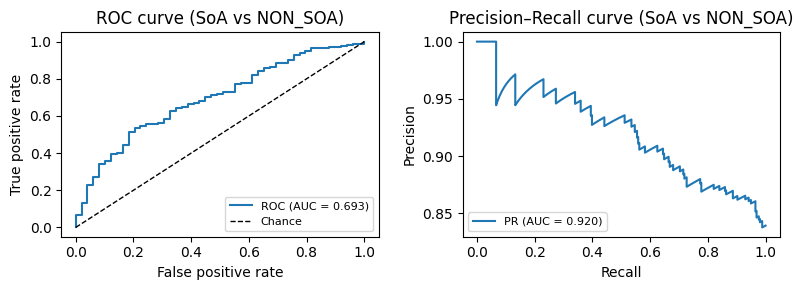

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

GOLD_FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner_meta_goldclf.csv"

# 1. Load gold set
df = pd.read_csv(GOLD_FILE, low_memory=False)

# 2. Keep only valid gold labels
soa_labels = {"POS_SOA", "NEG_SOA"}
all_labels = soa_labels | {"NON_SOA"}
df = df[df["Gold_Label"].isin(all_labels)].copy()

# 3. Ensure probability columns are numeric
prob_cols = ["meta_proba_POS_SOA", "meta_proba_NEG_SOA"]
for col in prob_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. Drop rows with NaNs in proba columns
mask_valid = df[prob_cols].notna().all(axis=1)
df = df[mask_valid].copy()

print(f"Rows remaining after cleaning: {len(df)}")
print("Gold label counts after cleaning:")
print(df["Gold_Label"].value_counts())

if len(df) == 0:
    raise ValueError("No rows left after cleaning; check meta_proba_* columns.")

# 5. Binary target: SoA (POS or NEG) vs NON_SOA
y_true = df["Gold_Label"].isin(soa_labels).astype(int).values

# 6. Positive-class probability: p(POS) + p(NEG)
p_pos = df["meta_proba_POS_SOA"].values
p_neg = df["meta_proba_NEG_SOA"].values
p_soa = p_pos + p_neg

if np.isnan(p_soa).any():
    raise ValueError("Still have NaNs in p_soa after cleaning.")

print("Sanity check: SoA vs NON_SOA counts")
print(pd.Series(y_true).value_counts().rename({0: "NON_SOA", 1: "SoA"}))

# 7. ROC curve
fpr, tpr, roc_thresh = roc_curve(y_true, p_soa)
roc_auc = auc(fpr, tpr)

# 8. Precision–Recall curve
precision, recall, pr_thresh = precision_recall_curve(y_true, p_soa)
pr_auc = average_precision_score(y_true, p_soa)

print(f"\nROC–AUC: {roc_auc:.3f}")
print(f"PR–AUC:  {pr_auc:.3f}")

# 9. Plot both curves side by side and SHOW them
plt.figure(figsize=(8, 3))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, lw=1.5, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve (SoA vs NON_SOA)")
plt.legend(loc="lower right", fontsize=8)

# PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=1.5, label=f"PR (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (SoA vs NON_SOA)")
plt.legend(loc="lower left", fontsize=8)

plt.tight_layout()
plt.show()   # <--- crucial in notebooks

# Optional: save for LaTeX
plt.savefig("meta_roc_pr_soa_vs_nonsoa.png", dpi=300, bbox_inches="tight")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
    matthews_corrcoef,
)

# 1. CONFIG
FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv"

# Column with human gold labels (3-way: POS_SOA / NEG_SOA / NON_SOA)
GOLD_COL = "Gold_Label"

# Column with fine-tuned BART’s predicted class labels (same label set)
PRED_COL = "bart_goldclf_soa_label"

# Optional probability columns for each class
PROBA_POS_COL = "bart_goldclf_proba_POS_SOA"
PROBA_NEG_COL = "bart_goldclf_proba_NEG_SOA"
PROBA_NON_COL = "bart_goldclf_proba_NON_SOA"

# 2. LOAD + BASIC CHECKS

df = pd.read_csv(FILE)
print(f"Loaded {len(df)} rows from: {FILE}")
print("Columns:", list(df.columns))

# Drop rows with missing gold or prediction
df = df.dropna(subset=[GOLD_COL, PRED_COL]).copy()
print(f"Rows after dropping missing gold/pred: {len(df)}")

y_true = df[GOLD_COL].astype(str)
y_pred = df[PRED_COL].astype(str)

labels = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# 3. MULTICLASS METRICS

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, labels=labels, average="macro")
kappa = cohen_kappa_score(y_true, y_pred, labels=labels)

print("\n=== Fine-tuned BART vs gold (3-way) ===")
print(f"Accuracy:     {acc:.3f}")
print(f"Macro F1:     {macro_f1:.3f}")
print(f"Cohen's κ:    {kappa:.3f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=labels, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"Gold_{l}" for l in labels],
                        columns=[f"Pred_{l}" for l in labels])
print("\nConfusion matrix (rows gold, cols predicted):")
print(cm_df)

# 4. SoA vs NON_SOA REDUCTION

# SoA = POS_SOA or NEG_SOA, Non-SoA = NON_SOA

y_true_bin = y_true.map(lambda x: 1 if x in {"POS_SOA", "NEG_SOA"} else 0)
y_pred_bin = y_pred.map(lambda x: 1 if x in {"POS_SOA", "NEG_SOA"} else 0)

# Try to build a probability-of-SoA score if class probabilities exist
have_probas = all(col in df.columns for col in [PROBA_POS_COL, PROBA_NEG_COL, PROBA_NON_COL])

if have_probas:
    p_pos = df[PROBA_POS_COL].astype(float)
    p_neg = df[PROBA_NEG_COL].astype(float)
    p_non = df[PROBA_NON_COL].astype(float)

    # SoA probability = P(POS_SOA) + P(NEG_SOA)
    p_soa = (p_pos + p_neg).clip(0.0, 1.0)

    # Clean any NaNs
    mask = p_soa.notna() & y_true_bin.notna()
    y_true_bin = y_true_bin[mask]
    y_pred_bin = y_pred_bin[mask]
    p_soa = p_soa[mask]

    # Binary metrics
    roc_auc = roc_auc_score(y_true_bin, p_soa)
    pr_auc = average_precision_score(y_true_bin, p_soa)
    brier = brier_score_loss(y_true_bin, p_soa)
    nll = log_loss(y_true_bin, p_soa, labels=[0, 1])
    mcc = matthews_corrcoef(y_true_bin, (p_soa >= 0.5).astype(int))

    print("\n=== Fine-tuned BART: SoA vs NON_SOA (using P(SoA) = P(POS)+P(NEG)) ===")
    print(f"ROC–AUC:          {roc_auc:.3f}")
    print(f"PR–AUC:           {pr_auc:.3f}")
    print(f"Brier score:      {brier:.4f}")
    print(f"NLL / X-entropy:  {nll:.4f}")
    print(f"MCC @thr=0.5:   {mcc:.3f}")
    print(f"n = {len(y_true_bin)}")

    # Calibration deciles
    df_cal = pd.DataFrame({"y_true": y_true_bin, "p_soa": p_soa})
    df_cal["bin"] = pd.qcut(df_cal["p_soa"], 10, duplicates="drop")
    cal = (
        df_cal.groupby("bin")
        .agg(pred_bin_mean=("p_soa", "mean"),
             empirical_freq=("y_true", "mean"))
        .reset_index(drop=True)
    )
    print("\nCalibration deciles:")
    print(cal)

else:
    print("\n[Warning] Probability columns for BART not found; skipping ROC/PR/Brier/NLL.")
    print("Expected:", PROBA_POS_COL, PROBA_NEG_COL, PROBA_NON_COL)


Loaded 63092 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv
Columns: ['proposition', 'Gold_Label', 'INFERRED_HUMAN_AGENCY', 'bart-large-mnli_entailment', 'bart-large-mnli_neutral', 'bart-large-mnli_contradiction', 'bart-large-mnli_agency_score', 'roberta-large-mnli_entailment', 'roberta-large-mnli_neutral', 'roberta-large-mnli_contradiction', 'roberta-large-mnli_agency_score', 'mean_agency_score', 'timestamp', 'sentiment_label', 'sentiment_score', 'sim_ai', 'lex', 'dep', 'combined_agency_score', 'bart_soa_label', 'bart_agency_related', 'roberta_soa_label', 'roberta_agency_related', 'combined_soa_label', 'combined_agency_related', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'bart_goldclf_soa_label', 'bart_goldclf_agency_score', 'bart_goldclf_agency_related']
Rows after dropping missing gold/pred: 305

=== Fine-tuned BART vs gold (3-way) ===
Accuracy:     0.797
Macro F1:     0.782
Cohen's κ:    0.670

Classification report:
       

/tmp/ipython-input-500851538.py:37: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE)


/tmp/ipython-input-1742221434.py:6: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE)


ROC–AUC (|score|): 0.9151785714285714
PR–AUC  (|score|): 0.9808332972553903
ROC–AUC (BART goldclf, SoA vs NON_SOA): 0.915
PR–AUC  (BART goldclf, SoA vs NON_SOA): 0.981
MCC at threshold 0.3: 0.108
n = 305


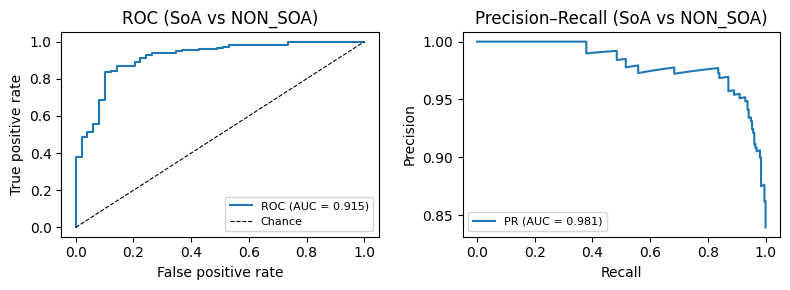

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bart_goldclf.csv"
df = pd.read_csv(FILE)

df = df.dropna(subset=["Gold_Label", "bart_goldclf_agency_score"]).copy()

y_true = df["Gold_Label"].astype(str).map(
    lambda x: 1 if x in {"POS_SOA", "NEG_SOA"} else 0
).values

score_mag = df["bart_goldclf_agency_score"].astype(float).abs()

fpr, tpr, _ = roc_curve(y_true, score_mag)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, score_mag)
pr_auc = average_precision_score(y_true, score_mag)

print("ROC–AUC (|score|):", roc_auc)
print("PR–AUC  (|score|):", pr_auc)

print(f"ROC–AUC (BART goldclf, SoA vs NON_SOA): {roc_auc:.3f}")
print(f"PR–AUC  (BART goldclf, SoA vs NON_SOA): {pr_auc:.3f}")
print(f"MCC at threshold 0.3: {mcc_03:.3f}")
print(f"n = {len(df)}")

# --- Plot ROC & PR for the paper ---

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--", linewidth=0.8, label="Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC (SoA vs NON_SOA)")
plt.legend(loc="lower right", fontsize=8)

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (SoA vs NON_SOA)")
plt.legend(loc="lower left", fontsize=8)

plt.tight_layout()
plt.show()
